Connected to venv (Python 3.12.3)

ANÁLISE DA CORRELAÇÃO DO AUMENTO POPULACIONAL COM A PIORA DA QUALIDADE DO AR E DA PIORA DA QUALIDADE DO AR COM O AUMENTO DE CASOS DE DOENÇAS RESPIRATÓRIAS

Em primeiro lugar, como dito no enunciado do trabalho é importante enfatizar quais são as limitações dos bancos de dados utilizados. Ao fazer as minhas análises, eu encontrei muita dificuldade de tirar certas conclusões por causa de limitações desses bancos, que podem ser interessantes de se adicionar no trabalho. Além das que vocês pensarem, Lucas e Giovanni, eu gostaria que adicionassem essas também:

- Limitação do banco de dados doenças: Os dados de notificações de doenças estão espalhados ao longo de muitos anos. Os dados de meningite por exemplo estão distribuidos entre 2007 e 2023 e em contrapartida os dados de influenza só estão presentes entre 2009 e 2010. E a única estatística que é contabilizada por cidade são os casos totais nesse período de tempo. Isso dificulta a análise exploratória, pois, potencialmente uma epidemia localizada e de tempo curto, onde houveram muitos casos, pode ser interpretada como um problema menor, mas crônica nas cidades, ao longo de muitos anos. Esse empecilho, impediu que fizessemos análises baseadas na progressão temporal das doenças, pois existiria uma chance muito grande de essas estarem erradas.

- Limitação do banco de dados do IQAR: Os bancos de dados de IQAR possuem muitas análises de qualidades do ar feitas para poucas cidades. Apesar do grande volume de medições, mais de 800K, apenas 69 cidades distintas tiveram suas medições feitas. Isso dificulta que análises interessantes sejam feitas de forma precisa, como a qualidade do ar por estado, ou a correlação entre doenças respiratórias específicas e a concentração de substâncias que são conhecidas por causar essas ditas doenças na literatura médica(como por exemplo a presência de ozônio e o aumento de casos de Asma).

- Limitação do banco de dados de município do IBGE: O banco de dados de municípios do IBGE têm um problema de chave primária. Cidades de mesmo nome podem estar associadas a diferentes códigos municipais, têm alguns nomes de cidades que estão presentes em mais de uma cidade no Brasil, como por exemplo o nome "Bom Jesus", existem 6 cidades com esse nome em diferentes estados brasileiros. Para solucionar esse problema, eu recomendaria que a chave primária fosse não apenas o nome da cidade, mas também a sigla da unidade federativa, dessa forma não haveria problemas de junção de tabelas do IBGE com outras que não possuem o código municipal como chave estrangeira.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install scikit-learn
import sklearn as sk

In [122]:
asma = pd.read_csv('./normalizado/asma-normalizado.csv',sep=';')
estacoes = pd.read_csv('./normalizado/estacoes-normalizado.csv',sep=';')
influenza = pd.read_csv('./normalizado/influenza-normalizado.csv',sep=';')
municipios = pd.read_csv('./normalizado/municipios-normalizado.csv',sep=';')
intoxicacoes = pd.read_csv('./normalizado/intoxicacoes-normalizado.csv',sep=';')
pneumo = pd.read_csv('./normalizado/pneumoconioses-normalizado.csv',sep=';')
populacao = pd.read_csv('./normalizado/populacao-normalizado.csv',sep=';')
meningite = pd.read_csv('./normalizado/meningite-normalizado.csv',sep=';')

In [3]:
qualidade_ar = pd.read_csv('./normalizado/qualidade_ar-parcialmente_normalizado.csv',sep=';')

Os 3 blocos de código acima simplesmente transformam cada um dos csv's acima para dataframes do pandas, que são como tabelas de SQL, usando o ';' em cada um dos csv's para separar por colunas. Além disso acima desse código são importadas as bibliotecas necessárias para fazer o tratamento e a análise de dados. 

In [4]:
qualidade_ar 

,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO
0,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE ENXOFRE,SO2,891,3400.0,22/11/2022,11:00,VA
1,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,22/11/2022,11:00,VA
2,CAMAÇARI,BA,CÂMARA,DIREÇÃO DO VENTO,DV,116732,NaN,22/11/2022,11:00,VA
3,CAMAÇARI,BA,CÂMARA,ÓXIDO NÍTRICO,NO,6156,NaN,22/11/2022,11:00,VA
4,CAMAÇARI,BA,CÂMARA,ÓXIDOS DE NITROGÊNIO,NOX,11846,NaN,22/11/2022,11:00,VA
...,...,...,...,...,...,...,...,...,...,...
838845,RIO DE JANEIRO,RJ,TIJUCA,UMIDADE RELATIVA,UR,84730,NaN,01/07/2022,00:00,VA
838846,RIO DE JANEIRO,RJ,TIJUCA,VENTO,VV,60,NaN,01/07/2022,00:00,VA
838847,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,DIÓXIDO DE ENXOFRE,SO2,860,2000.0,01/07/2022,00:00,VA
838848,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,DIÓXIDO DE NITROGÊNIO,NO2,9720,2000.0,01/07/2022,00:00,VA


In [5]:
municipios

,COD_MUNIC,NOME DO MUNICÍPIO
0,110001,ALTA FLORESTA D'OESTE
1,110002,ARIQUEMES
2,110003,CABIXI
3,110004,CACOAL
4,110005,CEREJEIRAS
...,...,...
5565,522200,VIANÓPOLIS
5566,522205,VICENTINÓPOLIS
5567,522220,VILA BOA
5568,522230,VILA PROPÍCIO


A primeira tarefa que vou fazer é juntar as tabelas de município e qualidade do ar, para que possamos mais tarde mapear cada código municipal à sua respectiva população, de forma que possamos estudar como a população de uma cidade impacta a qualidade do ar. Mais tarde, outras análises serão feitas, mas por enquanto essa manipulação de dataframes é tudo o que é necessário.

In [6]:
qualidade_ar = qualidade_ar.drop_duplicates()
municipios = municipios.drop_duplicates()

Código acima serve simplesmente para remover linhas totalmente duplicadas para garantir a consistência do dataframe.

In [7]:

teste = pd.merge(qualidade_ar, municipios, how ='left', left_on='NOME_MUNIC',right_on='NOME DO MUNICÍPIO')

In [8]:
teste

,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO,COD_MUNIC,NOME DO MUNICÍPIO
0,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE ENXOFRE,SO2,891,3400.0,22/11/2022,11:00,VA,290570,CAMAÇARI
1,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,22/11/2022,11:00,VA,290570,CAMAÇARI
2,CAMAÇARI,BA,CÂMARA,DIREÇÃO DO VENTO,DV,116732,NaN,22/11/2022,11:00,VA,290570,CAMAÇARI
3,CAMAÇARI,BA,CÂMARA,ÓXIDO NÍTRICO,NO,6156,NaN,22/11/2022,11:00,VA,290570,CAMAÇARI
4,CAMAÇARI,BA,CÂMARA,ÓXIDOS DE NITROGÊNIO,NOX,11846,NaN,22/11/2022,11:00,VA,290570,CAMAÇARI
...,...,...,...,...,...,...,...,...,...,...,...,...
863806,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,DIÓXIDO DE NITROGÊNIO,NO2,9720,2000.0,01/07/2022,00:00,VA,261570,TRIUNFO
863807,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,DIÓXIDO DE NITROGÊNIO,NO2,9720,2000.0,01/07/2022,00:00,VA,432200,TRIUNFO
863808,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,MONÓXIDO DE CARBONO,CO,20,0.0,01/07/2022,00:00,VA,251680,TRIUNFO
863809,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,MONÓXIDO DE CARBONO,CO,20,0.0,01/07/2022,00:00,VA,261570,TRIUNFO


Como podemos ver, ao usar o left join, o número de linhas do dataframe aumenta. Isso significa que existe algum dado duplicado em algum dos dois dataframes, vamos verificar qual é.

In [9]:
municipios['NOME DO MUNICÍPIO'].value_counts()

NOME DO MUNICÍPIO
BOM JESUS               5
SÃO DOMINGOS            5
BONITO                  4
SANTA HELENA            4
SANTA TEREZINHA         4
                       ..
CONCEIÇÃO DO JACUÍPE    1
CONCEIÇÃO DO COITÉ      1
CONCEIÇÃO DO ALMEIDA    1
CONCEIÇÃO DA FEIRA      1
BRASÍLIA                1
Name: count, Length: 5297, dtype: int64

In [10]:
municipios[municipios['NOME DO MUNICÍPIO']=='BOM JESUS']

,COD_MUNIC,NOME DO MUNICÍPIO
697,220190,BOM JESUS
1093,240170,BOM JESUS
1273,250220,BOM JESUS
4351,420253,BOM JESUS
4654,430230,BOM JESUS


Como visto acima, existem muitas cidades que estão duplicadas, pois existem múltiplos municípios com nomes diferentes em diferentes estados. Por isso, uma nova coluna de estado será adicionada no dataframe de município, usando os 2 primeiros digitos do código, para que o join possa ser feito usando tanto o estado quanto a cidade, de forma a garantir que a cidade indicada seja a correta.

In [11]:
# Dicionário que mapeia os códigos dos estados conforme o IBGE para as siglas dos estados
codigo_estado_ibge = {
    '11': 'RO',
    '12': 'AC',
    '13': 'AM',
    '14': 'RR',
    '15': 'PA',
    '16': 'AP',
    '17': 'TO',
    '21': 'MA',
    '22': 'PI',
    '23': 'CE',
    '24': 'RN',
    '25': 'PB',
    '26': 'PE',
    '27': 'AL',
    '28': 'SE',
    '29': 'BA',
    '31': 'MG',
    '32': 'ES',
    '33': 'RJ',
    '35': 'SP',
    '41': 'PR',
    '42': 'SC',
    '43': 'RS',
    '50': 'MS',
    '51': 'MT',
    '52': 'GO',
    '53': 'DF'
}

In [12]:
# Função para extrair a sigla do estado a partir do código do município
def get_uf_from_codigo(codigo):
    estado_codigo = str(codigo)[:2]  # Extrair os dois primeiros dígitos como string
    return codigo_estado_ibge.get(estado_codigo, 'Código não encontrado')

# Criar a nova coluna 'UF' no dataframe
municipios['UF'] = municipios['COD_MUNIC'].apply(lambda x: get_uf_from_codigo(x))


In [13]:
municipios

,COD_MUNIC,NOME DO MUNICÍPIO,UF
0,110001,ALTA FLORESTA D'OESTE,RO
1,110002,ARIQUEMES,RO
2,110003,CABIXI,RO
3,110004,CACOAL,RO
4,110005,CEREJEIRAS,RO
...,...,...,...
5565,522200,VIANÓPOLIS,GO
5566,522205,VICENTINÓPOLIS,GO
5567,522220,VILA BOA,GO
5568,522230,VILA PROPÍCIO,GO


Dessa forma conseguimos garantir que, quando fizermos o join, o código certo será mapeado para a cidade certa. Agora, basta testar se o mapeamento está certo. Podemos fazer isso verificando se o número de municípios por estado corresponde ao da vida real.

In [14]:
municipios['UF'].value_counts()

UF
MG    853
SP    645
RS    497
BA    417
PR    399
SC    295
GO    246
PI    224
PB    223
MA    217
PE    185
CE    184
RN    167
PA    144
MT    141
TO    139
AL    102
RJ     92
MS     79
ES     78
SE     75
AM     62
RO     52
AC     22
AP     16
RR     15
DF      1
Name: count, dtype: int64

Esses dados conferem com o número oficial de municípios registrados por estado em 2021, demonstrando que a função funcionou corretamente, e cada cidade está mapeada para o seu respectivo estado. Agora basta unir as duas tabelas.

In [15]:
pd.merge(qualidade_ar,municipios, left_on=['NOME_MUNIC','UF'], right_on=['NOME DO MUNICÍPIO','UF'], how='inner')

,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO,COD_MUNIC,NOME DO MUNICÍPIO
0,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE ENXOFRE,SO2,891,3400.0,22/11/2022,11:00,VA,290570,CAMAÇARI
1,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,22/11/2022,11:00,VA,290570,CAMAÇARI
2,CAMAÇARI,BA,CÂMARA,DIREÇÃO DO VENTO,DV,116732,NaN,22/11/2022,11:00,VA,290570,CAMAÇARI
3,CAMAÇARI,BA,CÂMARA,ÓXIDO NÍTRICO,NO,6156,NaN,22/11/2022,11:00,VA,290570,CAMAÇARI
4,CAMAÇARI,BA,CÂMARA,ÓXIDOS DE NITROGÊNIO,NOX,11846,NaN,22/11/2022,11:00,VA,290570,CAMAÇARI
...,...,...,...,...,...,...,...,...,...,...,...,...
838776,RIO DE JANEIRO,RJ,TIJUCA,UMIDADE RELATIVA,UR,84730,NaN,01/07/2022,00:00,VA,330455,RIO DE JANEIRO
838777,RIO DE JANEIRO,RJ,TIJUCA,VENTO,VV,60,NaN,01/07/2022,00:00,VA,330455,RIO DE JANEIRO
838778,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,DIÓXIDO DE ENXOFRE,SO2,860,2000.0,01/07/2022,00:00,VA,432200,TRIUNFO
838779,TRIUNFO,RS,TRIUNFO/POLO PETROQUÍMICO/MÓVEL,DIÓXIDO DE NITROGÊNIO,NO2,9720,2000.0,01/07/2022,00:00,VA,432200,TRIUNFO


In [16]:
qualidade_municipio = pd.merge(qualidade_ar,municipios, left_on=['NOME_MUNIC','UF'], right_on=['NOME DO MUNICÍPIO','UF'], how='inner')

A tabela está consistente. Agora basta dropar as colunas de nomes duplicados e depois podemos mapear cada cidade à sua respectiva população.

In [17]:
populacao

,COD_MUNIC,POP
0,110001,22516
1,110002,111148
2,110003,5067
3,110004,86416
4,110005,16088
...,...,...
5565,522200,14088
5566,522205,9002
5567,522220,6451
5568,522230,5941


In [18]:
pd.merge(populacao,qualidade_municipio,on='COD_MUNIC',how='inner')

,COD_MUNIC,POP,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO,NOME DO MUNICÍPIO
0,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE ENXOFRE,SO2,891,3400.0,22/11/2022,11:00,VA,CAMAÇARI
1,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,22/11/2022,11:00,VA,CAMAÇARI
2,290570,309208,CAMAÇARI,BA,CÂMARA,DIREÇÃO DO VENTO,DV,116732,NaN,22/11/2022,11:00,VA,CAMAÇARI
3,290570,309208,CAMAÇARI,BA,CÂMARA,ÓXIDO NÍTRICO,NO,6156,NaN,22/11/2022,11:00,VA,CAMAÇARI
4,290570,309208,CAMAÇARI,BA,CÂMARA,ÓXIDOS DE NITROGÊNIO,NOX,11846,NaN,22/11/2022,11:00,VA,CAMAÇARI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838776,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,RADIAÇÃO SOLAR,RAD,-17500,NaN,01/07/2022,00:00,IN,TRÊS LAGOAS
838777,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,CHUVA,CH,0,NaN,01/07/2022,00:00,VA,TRÊS LAGOAS
838778,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIÓXIDO DE ENXOFRE,SO2,34630,71789.0,01/07/2022,00:00,VA,TRÊS LAGOAS
838779,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIREÇÃO DO VENTO,DV,339291,NaN,01/07/2022,00:00,VA,TRÊS LAGOAS


In [19]:
qualidade_municipio_pop = pd.merge(populacao,qualidade_municipio,on='COD_MUNIC',how='inner')

In [20]:
qualidade_municipio_pop.drop(columns=['NOME DO MUNICÍPIO'])

,COD_MUNIC,POP,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO
0,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE ENXOFRE,SO2,891,3400.0,22/11/2022,11:00,VA
1,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,22/11/2022,11:00,VA
2,290570,309208,CAMAÇARI,BA,CÂMARA,DIREÇÃO DO VENTO,DV,116732,NaN,22/11/2022,11:00,VA
3,290570,309208,CAMAÇARI,BA,CÂMARA,ÓXIDO NÍTRICO,NO,6156,NaN,22/11/2022,11:00,VA
4,290570,309208,CAMAÇARI,BA,CÂMARA,ÓXIDOS DE NITROGÊNIO,NOX,11846,NaN,22/11/2022,11:00,VA
...,...,...,...,...,...,...,...,...,...,...,...,...
838776,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,RADIAÇÃO SOLAR,RAD,-17500,NaN,01/07/2022,00:00,IN
838777,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,CHUVA,CH,0,NaN,01/07/2022,00:00,VA
838778,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIÓXIDO DE ENXOFRE,SO2,34630,71789.0,01/07/2022,00:00,VA
838779,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIREÇÃO DO VENTO,DV,339291,NaN,01/07/2022,00:00,VA


Podemos agora começar a nossa análise. Vamos, por enquanto, analisar apenas uma substância para ver o quanto a concentração dela no ar é modificada com a diferença populacional.

In [21]:
qualidade_municipio_pop_no2 = qualidade_municipio_pop[qualidade_municipio_pop['SIGLA'] == 'NO2']

In [22]:
qualidade_municipio_pop_no2

,COD_MUNIC,POP,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO,NOME DO MUNICÍPIO
1,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,22/11/2022,11:00,VA,CAMAÇARI
10,290570,309208,CAMAÇARI,BA,GRAVATÁ,DIÓXIDO DE NITROGÊNIO,NO2,1268,3020.0,22/11/2022,11:00,VA,CAMAÇARI
27,290570,309208,CAMAÇARI,BA,MACHADINHO,DIÓXIDO DE NITROGÊNIO,NO2,3448,1460.0,22/11/2022,11:00,VA,CAMAÇARI
39,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,4946,5120.0,22/11/2022,10:00,VA,CAMAÇARI
48,290570,309208,CAMAÇARI,BA,GRAVATÁ,DIÓXIDO DE NITROGÊNIO,NO2,1152,3020.0,22/11/2022,10:00,VA,CAMAÇARI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838732,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO METEREOLÓGICA E QUALIDADE DO AR - PETR...,DIÓXIDO DE NITROGÊNIO,NO2,21219,4200.0,01/07/2022,01:30,VA,TRÊS LAGOAS
838743,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIÓXIDO DE NITROGÊNIO,NO2,15956,3200.0,01/07/2022,01:00,VA,TRÊS LAGOAS
838753,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - ELDORADO BRASIL CEL...,DIÓXIDO DE NITROGÊNIO,NO2,17,0.0,01/07/2022,00:30,VA,TRÊS LAGOAS
838761,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO METEREOLÓGICA E QUALIDADE DO AR - PETR...,DIÓXIDO DE NITROGÊNIO,NO2,29673,6000.0,01/07/2022,00:30,VA,TRÊS LAGOAS


Vamos verificar como a concentração de no2 varia com a população. Para isso, usaremos uma matriz de correlação, que determina como o aumento, ou diminuição de um fator afeta os outros.

In [23]:
!pip install seaborn
import seaborn as sns

Aqui eu só to instalando uma biblioteca que tinha esquecido kkkkkkkk

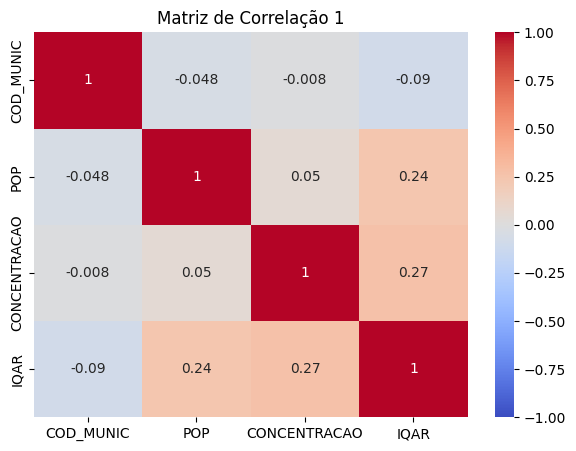

In [161]:
numeric_columns_no2_pop = qualidade_municipio_pop_no2.select_dtypes(include='number')
corr_matrix = numeric_columns_no2_pop.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação 1')
plt.show()

Essa matriz de correlação pode ser interpretada da seguinte forma: Quanto mais próximo de 1, um valor aumenta muito à medida que o outro também, e quanto mais perto de -1, um valor diminui à medida que o outro aumenta. À partir dessa matriz de correlação, podemos tirar algumas conclusões interessantes:

- Os dois fatores mais intimamente relacionados são o IQAR(Índice de qualidade do ar) e a população, com uma relação de 0.27. Quanto maior o IQAR, pior a qualidade do ar. Isso significa, portanto que quanto maior a população de uma cidade pior a qualidade do seu ar, e essas duas métricas estão intimamente relacionadas.

- Além disso, podemos ver que a concetração de NO2 no ar possui uma relação de 0.05 conforme há aumento populacional. Isso pode parecer marginal, mas de forma alguma é, 0.05 é uma relação considerável, e mostra que nas grandes cidades a concentração de dióxido de nitrogênio tende a ser maior.

- Interessantemente, o índice de qualidade do ar está negativamente relacionado com o CÓDIGO DE MUNICÍPIO, com uma relação de -0.09, bastante considerável. Isso pode, à primeira vista parecer absurdo, mas como você pode observar no dicionário que mapeia o estado ao seu respectivo código, estados próximos tendem a ter números próximos, e estados mais ao norte tendem a ter códigos menores(todos os estados de norte e nordeste tem códigos que começam com 1 ou 2, já os estados do sudeste, centro-oeste e sul tem códigos que começam com 3, 5 e 4 respectivamente). O código do município sempre começa com o código do seu estado. O que isso indica é que os municípios de estados do norte, e possivelmente os municípios de estados do nordeste, possuem, em média, uma maior qualidade do ar.

1 - Parte 2 da análise. Agora será feita uma análise da correlação da diminuição da qualidade do ar em geral, em cidades com quantidades semelhantes de pessoas, com o aumento de doenças respiratórias.

In [25]:
qualidade_municipio_pop

,COD_MUNIC,POP,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO,NOME DO MUNICÍPIO
0,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE ENXOFRE,SO2,891,3400.0,22/11/2022,11:00,VA,CAMAÇARI
1,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,22/11/2022,11:00,VA,CAMAÇARI
2,290570,309208,CAMAÇARI,BA,CÂMARA,DIREÇÃO DO VENTO,DV,116732,NaN,22/11/2022,11:00,VA,CAMAÇARI
3,290570,309208,CAMAÇARI,BA,CÂMARA,ÓXIDO NÍTRICO,NO,6156,NaN,22/11/2022,11:00,VA,CAMAÇARI
4,290570,309208,CAMAÇARI,BA,CÂMARA,ÓXIDOS DE NITROGÊNIO,NOX,11846,NaN,22/11/2022,11:00,VA,CAMAÇARI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838776,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,RADIAÇÃO SOLAR,RAD,-17500,NaN,01/07/2022,00:00,IN,TRÊS LAGOAS
838777,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,CHUVA,CH,0,NaN,01/07/2022,00:00,VA,TRÊS LAGOAS
838778,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIÓXIDO DE ENXOFRE,SO2,34630,71789.0,01/07/2022,00:00,VA,TRÊS LAGOAS
838779,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIREÇÃO DO VENTO,DV,339291,NaN,01/07/2022,00:00,VA,TRÊS LAGOAS


In [28]:
qualidade_municipio_pop['NOME_MUNIC'].value_counts()

NOME_MUNIC
RIO DE JANEIRO             150409
CAMAÇARI                   126063
DIAS D'ÁVILA               114260
TRÊS LAGOAS                 62255
SÃO PAULO                   53287
                            ...  
PIRAPORA                      714
MARIANA                       709
OURO PRETO                    688
SANTA CRUZ DO ESCALVADO       506
CORONEL FABRICIANO            402
Name: count, Length: 69, dtype: int64

Como podemos ver, para todas as cidades que tiveram as sua qualidade do ar medida, muitas medições foram feitas em todas as cidades. Essas medições variam com a passagem dos meses e anos, mas, principalmente, com o decorrer do dia, pois a presença de carros e o funcionamento de indústrias, por exemplo, varia ao longo do dia. Portanto, vamos pegar a média populacional e a média do IQAR agrupando-os por cidade, ao longo de todo o período avaliado, dessa forma podemos ter um entendimento mais fidedigno da relação entre casos de meningite e a qualidade do ar nas cidades.

In [116]:
qualidade_municipio_pop_teste = qualidade_municipio_pop.dropna(subset=['IQAR'])
qualidade_municipio_pop_teste

,COD_MUNIC,POP,NOME_MUNIC,UF,NOME_ESTACAO,ITEM_MONITORADO,SIGLA,CONCENTRACAO,IQAR,DATA,HORA,SITUACAO,NOME DO MUNICÍPIO
0,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE ENXOFRE,SO2,891,3400.0,2022-11-22,11:00,VA,CAMAÇARI
1,290570,309208,CAMAÇARI,BA,CÂMARA,DIÓXIDO DE NITROGÊNIO,NO2,5670,5120.0,2022-11-22,11:00,VA,CAMAÇARI
5,290570,309208,CAMAÇARI,BA,CÂMARA,OZÔNIO,O3,32797,10520.0,2022-11-22,11:00,VA,CAMAÇARI
9,290570,309208,CAMAÇARI,BA,GRAVATÁ,DIÓXIDO DE ENXOFRE,SO2,289,2000.0,2022-11-22,11:00,VA,CAMAÇARI
10,290570,309208,CAMAÇARI,BA,GRAVATÁ,DIÓXIDO DE NITROGÊNIO,NO2,1268,3020.0,2022-11-22,11:00,VA,CAMAÇARI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838761,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO METEREOLÓGICA E QUALIDADE DO AR - PETR...,DIÓXIDO DE NITROGÊNIO,NO2,29673,6000.0,2022-07-01,00:30,VA,TRÊS LAGOAS
838773,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,OZÔNIO,O3,3000,1200.0,2022-07-01,00:00,VA,TRÊS LAGOAS
838774,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIÓXIDO DE NITROGÊNIO,NO2,20955,4200.0,2022-07-01,00:00,VA,TRÊS LAGOAS
838778,500830,125137,TRÊS LAGOAS,MS,ESTAÇÃO DE MONITORAMENTO - SUZANO TLS1-VCPTL -...,DIÓXIDO DE ENXOFRE,SO2,34630,71789.0,2022-07-01,00:00,VA,TRÊS LAGOAS


Aqui eu apenas dropei as linhas que não tinham o índice de qualidade do ar, para que isso não atrapalhasse na análise.

In [134]:
grouped = qualidade_municipio_pop_teste.groupby(['NOME_MUNIC']).agg(
    {
     'NOME_MUNIC':'first',
     'POP':'mean',
     'IQAR':'mean',
     'COD_MUNIC':'first',
     'UF':'first'})

Aqui eu apenas agrupei e calculei a média de população e IQAR por cidade.

In [135]:
grouped

,NOME_MUNIC,POP,IQAR,COD_MUNIC,UF
NOME_MUNIC,,,,,
AMERICANA,AMERICANA,244370.0,35073.084825,350160,SP
ARARAQUARA,ARARAQUARA,240542.0,35555.653451,350320,SP
ARAUCÁRIA,ARAUCÁRIA,148522.0,12691.300281,410180,PR
ARAÇATUBA,ARAÇATUBA,199210.0,31590.868663,350280,SP
BARRA LONGA,BARRA LONGA,4905.0,16197.468354,310570,MG
...,...,...,...,...,...
TIMÓTEO,TIMÓTEO,91268.0,22507.478714,316870,MG
TRIUNFO,TRIUNFO,30159.0,2032.212544,432200,RS
TRÊS LAGOAS,TRÊS LAGOAS,125137.0,8441.289659,500830,MS


In [136]:
meningite

,COD_MUNIC,NOTIFICACOES
0,110001,3
1,110002,8
2,110004,267
3,110005,2
4,110006,1
...,...,...
2548,522160,7
2549,522170,1
2550,522185,4
2551,522190,2


Das doenças observas, a que possui mais cidades onde os casos foram notificados é a meningite. Por isso, irei analisar a meningite em específico, pois o maior número de notificações de casos contribui para a consistência e confiabilidade dos resultados. Na célula abaixo, apenas dei left join no dataframe agrupado com o dataframe de casos de meningite, à partir do código municipal.

In [146]:
grouped_meningite = pd.merge(grouped,meningite,on='COD_MUNIC')
grouped_meningite

,NOME_MUNIC,POP,IQAR,COD_MUNIC,UF,NOTIFICACOES
0,AMERICANA,244370.0,35073.084825,350160,SP,1148
1,ARARAQUARA,240542.0,35555.653451,350320,SP,361
2,ARAUCÁRIA,148522.0,12691.300281,410180,PR,137
3,ARAÇATUBA,199210.0,31590.868663,350280,SP,1086
4,BARRA LONGA,4905.0,16197.468354,310570,MG,1
...,...,...,...,...,...,...
61,TIMÓTEO,91268.0,22507.478714,316870,MG,32
62,TRIUNFO,30159.0,2032.212544,432200,RS,13
63,TRÊS LAGOAS,125137.0,8441.289659,500830,MS,65
64,VILA VELHA,508655.0,9480.214986,320520,ES,289


A célula abaixo, talvez seja a mais importante da análise. Nela eu calculo o número de casos de meningite por 100K habitantes, para cada uma das cidades mencionadas. É importante observar, que, segundo a epidemiologia, a disseminação de doenças respiratórias costuma ter caráter exponencial em relação à população.

O que isso significa, é que, mesmo com um IQAR parecido, muitas vezes o número de casos por 100K habitantes de uma cidade com uma população muito grande será maior que o de uma de população menor. Dito isso, eu inclui na minha análise apenas cidades entre 400k e 100k habitantes, pois creio que o comportamento de metrópoles, como São Paulo e Rio de Janeiro, costuma ser extremamente enviesado. Dessa forma, conseguimos ter uma maior consistência nos resultados. 

In [155]:
grouped_meningite['CASOS/100K'] = grouped_meningite['NOTIFICACOES']/grouped_meningite['POP']*100000
grouped_meningite = grouped_meningite.sort_values(by='POP',ascending=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
filtered_grouped_meningite = grouped_meningite[(grouped_meningite['POP'] >= 100000) & (grouped_meningite['POP'] <= 400000)]
filtered_grouped_meningite

,NOME_MUNIC,POP,IQAR,COD_MUNIC,UF,NOTIFICACOES,CASOS/100K
15,CORONEL FABRICIANO,110709.0,22521.658986,311940,MG,103,93.036700
37,PAULÍNIA,114508.0,31232.312566,353650,SP,262,228.804974
26,ITABIRA,121717.0,10302.748931,313170,MG,23,18.896292
12,CATANDUVA,123114.0,37520.597015,351110,SP,764,620.563055
22,GUARATINGUETÁ,123192.0,26969.345100,351840,SP,62,50.327943
59,TATUÍ,124134.0,24736.267071,355400,SP,267,215.090145
63,TRÊS LAGOAS,125137.0,8441.289659,500830,MS,65,51.943070
16,CUBATÃO,132521.0,43779.808653,351350,SP,274,206.759683
2,ARAUCÁRIA,148522.0,12691.300281,410180,PR,137,92.242227
28,JAÚ,153463.0,27279.472141,352530,SP,270,175.938174


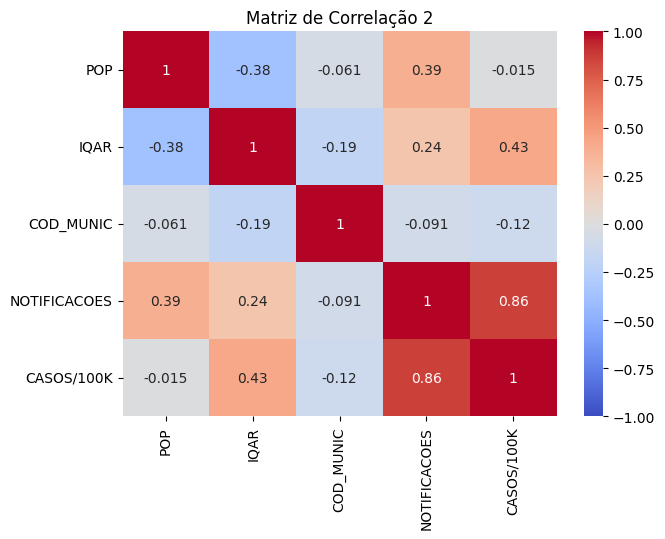

In [160]:
numeric_columns_filtered_grouped_meningite = filtered_grouped_meningite.select_dtypes(include='number')
corr_matrix_2 = numeric_columns_filtered_grouped_meningite.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação 2')
plt.show()


- O número mais relevante que se pode tirar dessa matriz de correlação é a relação do IQAR com o número de casos de meningite/100K habitantes, com uma relação de 0.43, EXTREMAMENTE alta. Isso significa, que quanto maior o IQAR(Lembrando que quanto maior o IQAR, pior a qualidade do ar) maior o número de casos de meningite por 100k habitantes. Isso provavelmente se deve ao fato de que uma piora da qualidade do ar diminui a potência do sistema imunológico das pessoas, o que dificulta que infecções em seu estágio inicial sejam combatidas antes que se disseminem pelo corpo e se tornem sintomáticas. Além disso, a meningite é uma doença primariamente transmitida pelo ar, aumentando ainda mais a quantidade de casos.